<a href="https://colab.research.google.com/github/lethanhnam1203/Machine-Deep-Learning-/blob/main/FGSM_Adversarial_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision.datasets as datasets
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import logging

In [ ]:
cifar10_transform = transforms.Compose([transforms.ToTensor(), 
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                        ])

In [ ]:
# Load the CIFAR10 Dataset
NUM_TRAIN = 40000

cifar10_train = datasets.CIFAR10(root='data', train=True, download=True,
                             transform=cifar10_transform)
cifar10_loader_train = DataLoader(cifar10_train, batch_size=128, num_workers=2, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = datasets.CIFAR10(root='data', train=True, download=True,
                           transform=cifar10_transform)
cifar10_loader_val = DataLoader(cifar10_val, batch_size=128, num_workers=2, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = datasets.CIFAR10(root='data', train=False, download=True, 
                            transform=cifar10_transform)
cifar10_loader_test = DataLoader(cifar10_test, batch_size=128, num_workers=2)


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
cd gdrive/MyDrive/dl_hw12

/content/gdrive/MyDrive/dl_hw12


In [ ]:
from models import ResNet18
rn_model = ResNet18()
rn_model.load_state_dict(torch.load("resnet18-cifar10.pth"))
rn_model.eval()
rn_model = rn_model.to(device=torch.device('cuda'))

In [ ]:
device = torch.device('cuda')
dtype = dtype=torch.float32
def check_accuracy_part34(test_loader, model):
    if test_loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [ ]:
check_accuracy_part34(cifar10_loader_test, rn_model)

Checking accuracy on test set
Got 9427 / 10000 correct (94.27)


0.9427

## Task 2a:
Implement the fast gradient sign method (FGSM) and clip the values of the adversarial images to [-1,1]

In [ ]:
def fgsm_fool(epsilon, image_gradient, image):
  """
  Input:
  epsilon -- float, the constant hyperparameter
  image_gradient -- tensor, deriative of the loss wrt original image
  image -- tensor, original image, same size with image_gradient

  Output:
  adversarial_image -- tensor, pertubed image that may lead to misclassification,
                        same size with image and image_gradient

  """
  sign_image_gradient = image_gradient.sign()
  eta = epsilon * sign_image_gradient
  adversarial_image = image + eta
  adversarial_image = torch.clamp(adversarial_image, -1, 1)
  return adversarial_image

## Task 2b:
The fooling rate is the relative amount of adversarial images that resulted in a different prediction by the model. Plot different values of epsilon agaisnt the resulting folling rates on the test data.

In [ ]:
def calculate_fooling_rate(model, test_loader, epsilon, verbose=True):
    """
    Input:
    model -- 
    test_loader -- 
    epsilon -- hyperparameter

    Output:
    fooling_rate -- the rate of images that are classified differently after pertubation
    """
    device = torch.device('cuda')
    num_incorrect = 0
    num_samples = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        naive_output = model(data)
        naive_output = F.log_softmax(naive_output, dim=1) # Classify the images
        loss = F.nll_loss(naive_output, target) # Calculate the loss

        model.zero_grad() # Zero all existing gradients
        loss.backward() # Calculate gradients in the backward pass 
        data_grad = data.grad.data # Collect gradients of input data
 
        adv_data = fgsm_fool(epsilon, data_grad, data) # Summon FGSM Attack
        adv_output = model(adv_data) 
        adv_output = F.log_softmax(adv_output, dim=1) # Re-classify the adverserial images

        # Check for changes in classification
        _, naive_pred = naive_output.max(1) 
        _, adv_pred = adv_output.max(1) 
        num_incorrect += (naive_pred != adv_pred).sum()
        num_samples += naive_pred.size(0)

    fooling_rate = (num_incorrect/num_samples).item()
    if verbose:
        print("Epsilon = {} and Pooling Rate = {}".format(epsilon, fooling_rate))
    else:
        return fooling_rate      

In [ ]:
calculate_fooling_rate(rn_model, cifar10_loader_test, epsilon=0.1)

Epsilon = 0.1 and Pooling Rate = 0.7019999623298645


In [ ]:
epsilon_list = [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25, 0.3]
fooling_rate_list = []
for epsilon in epsilon_list:
    fooling_rate = calculate_fooling_rate(rn_model, cifar10_loader_test, epsilon=eps, verbose=False)
    fooling_rate_list.append(fooling_rate)
print(fooling_rate_list)

[0.0, 0.49469998478889465, 0.5748999714851379, 0.637499988079071, 0.7019999623298645, 0.7518999576568604, 0.7828999757766724, 0.8203999996185303, 0.8364999890327454, 0.8398999571800232]


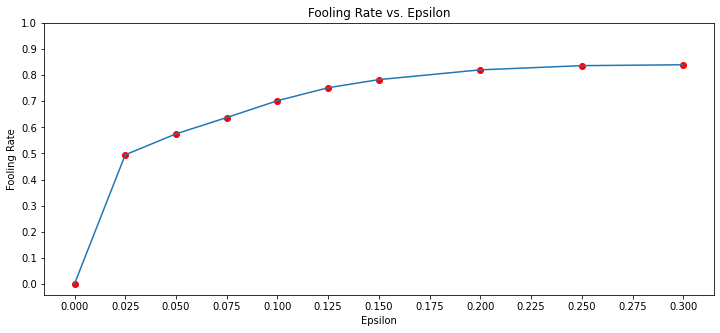

In [ ]:
# Visualisation
plt.figure(figsize=(12,5))
plt.scatter(epsilon_list, fooling_rate_list, color = 'red')
plt.plot(epsilon_list, fooling_rate_list)
plt.title("Fooling Rate vs. Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Fooling Rate")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.325, step=0.025))
plt.show()

## Task 2c: 
Find a value of epsilon that results in a fooling rate of 0.7 on the test data. Visualise at least 10 different adversarial images and compare them with the original images? Can you recognise the adversity with your human eyes?

In [ ]:
# copy from a previous homework
def plot_images(images, cls_true, cls_pred=None, clas_adv=None):
    """
    This function plot images with their labels.
    """
    # CIFAR10 labels
    labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    fig, axes = plt.subplots(3, 5)
    for i, ax in enumerate(axes.flat):
        # plot imgages
        ax.imshow(images[i, :, :, :], interpolation='spline16')
        # show true & predicted classes
        cls_true_name = labels[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = labels[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name)
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [ ]:
def pre_visualise(model, data_loader, epsilon):
    """
    Input:
    model --
    data loader --

    Output:
    naive_X -- 
    naive_pred --
    adv_X --
    adv_pred --
    """
    data_iter = iter(data_loader)
    data, target = data_iter.next()
    data, target = data.to(torch.device('cuda')), target.to(torch.device('cuda'))

    data.requires_grad = True
    naive_output = model(data)
    naive_output = F.log_softmax(naive_output, dim=1) # Classify the images
    loss = F.nll_loss(naive_output, target) # Calculate the loss
    model.zero_grad() # Zero all existing gradients
    loss.backward() # Calculate gradients in the backward pass 
    data_grad = data.grad.data # Collect gradients of input data
    adv_data = fgsm_fool(epsilon, data_grad, data) # Summon FGSM Attack
    adv_output = model(adv_data) 
    adv_output = F.log_softmax(adv_output, dim=1) # Re-classify the adverserial images
    _, naive_pred = naive_output.max(1) 
    _, adv_pred = adv_output.max(1) 

    data_cpu = data.to(torch.device('cpu'))
    data_cpu = data_cpu.detach().numpy()
    naive_X = data_cpu.transpose([0, 2, 3, 1])

    adv_data_cpu = adv_data.to(torch.device('cpu'))
    adv_data_cpu = adv_data_cpu.detach().numpy()
    adv_X = adv_data_cpu.transpose([0, 2, 3, 1]) 

    return naive_X, naive_pred, adv_X, adv_pred 


def visualise(model, data_loader, epsilon):
    """
    plot original images and adversarial images with eta noise
    for comparision
    """
    logger = logging.getLogger() # to dismiss the logging message since we clip input data to [-1, 1], not [0, 1] as prefered by plt.imshow
    old_level = logger.level
    logger.setLevel(100)

    naive_X, naive_pred, adv_X, adv_pred = pre_visualise(model, data_loader, epsilon)
    print("Original images after clippings to [-1, 1]")
    plot_images(naive_X, naive_pred)
    print("\nAdversarial images after adding noise eta")
    plot_images(adv_X, adv_pred)

    logger.setLevel(old_level)

Original images after clippings to [-1, 1]


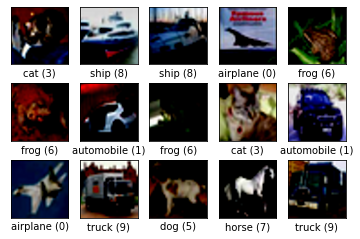


Adversarial images after adding noise eta


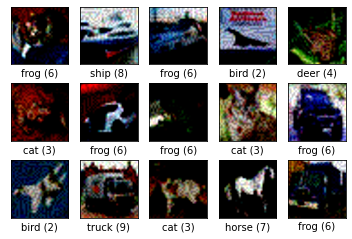

In [ ]:
eps = 0.100
visualise(rn_model, cifar10_loader_test, epsilon = eps)

I can still recognise many of the adversial images. 